In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline


In [10]:

def build_qgb(n_levels: int) -> QuantumCircuit:
    
    L = n_levels
    n_pos = 2 * L + 1            
    center = L                   

    
    ancilla = QuantumRegister(1, "ancilla")        
    qubit_pos  = QuantumRegister(n_pos, "qubit_pos")     
    bin_indices = [i for i in range(n_pos) if (i - center) % 2 == 0]  
    creg = ClassicalRegister(len(bin_indices), "c")

    qc = QuantumCircuit(ancilla, qubit_pos, creg)

    
    qc.x(qubit_pos[center])

   
    for level in range(L):
        
        qc.reset(ancilla[0])
        qc.h(ancilla[0])

        
        start = center - (level + 1)
        end   = center + level
        for j in range(start, end + 1):
            
            qc.append(CSwapGate(), [ancilla[0], qubit_pos[j], qubit_pos[j + 1]])

            
            qc.cx(qubit_pos[j + 1], ancilla[0])

    
    for k, i in enumerate(bin_indices):
        qc.measure(qubit_pos[i], creg[k])

    return qc, bin_indices




In [11]:
def post_process_bins(counts, n_levels, bin_indices):
    
    L = n_levels
    bin_counts = Counter()
    for bitstring, c in counts.items():
        
        bits = bitstring[::-1]
        if bits.count('1') == 1:
            b = bits.index('1')
            bin_counts[b] += c
    return dict(bin_counts)



Processed (bin-index) counts: {8: 3, 0: 5, 4: 273, 5: 230, 3: 218, 6: 111, 7: 36, 1: 46, 2: 102}


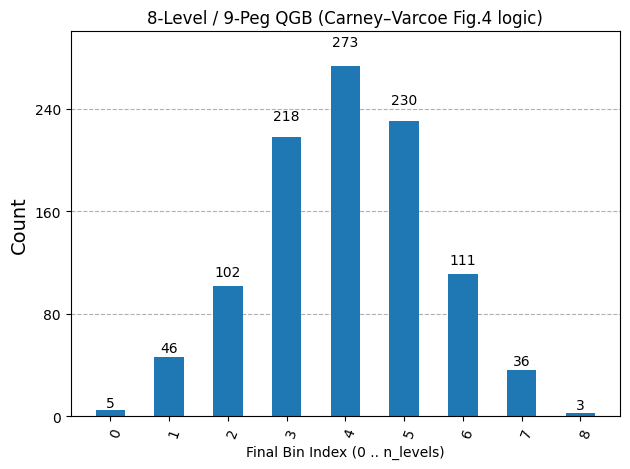

In [15]:
def run_qgb(n_levels=8, shots=1024, draw=False):
    qc, bin_indices = build_qgb(n_levels)
    if draw:
        display(qc.draw("mpl"))

    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    bin_counts = post_process_bins(counts, n_levels, bin_indices)
    print("Processed (bin-index) counts:", bin_counts)

    
    labeled = {str(k): v for k, v in sorted(bin_counts.items())}
    plot_histogram(labeled, sort='asc')
    plt.title(f"{n_levels}-Level / {n_levels+1}- QGB ")
    plt.xlabel("Final Bin Index (0 .. n_levels)")
    plt.tight_layout()
    plt.show()

    return qc, counts, bin_counts

# ---- example ----
if __name__ == "__main__":
    qc, counts, bin_counts = run_qgb_varcoe(n_levels= 8, shots = 1024, draw=False)